In [1]:
%pip install --upgrade pip
%pip install davos
import davos

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle pandas as pd # pip: pandas==1.5.1
smuggle numpy as np # pip: numpy==1.23.4
smuggle seaborn as sns # pip: seaborn==0.12.1
from matplotlib smuggle pyplot as plt #pip: matplotlib==3.6.2
smuggle openpyxl as pxl # pip: openpyxl==3.0.9

smuggle os

from dataloader import datadir
from analyze import analyze_data

datadir = os.path.split(datadir)[0]

figdir = os.path.join(os.path.split(os.getcwd())[0], 'paper', 'figures', 'source')
if not os.path.exists(figdir):
    os.makedirs(figdir)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 7.2 MB/s eta 0:00:00


Load in data and clean it up (first pass)

In [3]:
demographics = pd.read_excel(os.path.join(datadir, 'demographics.xlsx'))

demographics['Experiment'] = demographics['ID'].apply(lambda x: '-'.join(x.upper().split('-')[:2]))
demographics['Experimenter'] = demographics['Experimenter'].apply(lambda x: x.split(' ')[0].capitalize())
demographics['Gender'].fillna('Gender not specified', inplace=True)
demographics['Ethnicity'].fillna('Ethnicity not specified', inplace=True)
demographics['Race'].fillna('Race not specified', inplace=True)
demographics['Reading impairments'] = demographics['Reading impairments'].apply(lambda x: x == 'Yes')
demographics['Normal color vision'] = demographics['Normal color vision'].apply(lambda x: x == 'Yes')
demographics['Meds or injuries'].fillna('None', inplace=True)
demographics['Coffee (cups)'].fillna(0, inplace=True)

alert_dict = {'Very sluggish': -2, 'A little sluggish': -1, 'Neutral': 0, 'A little alert': 1, 'Very alert': 2}
demographics['Alert'] = demographics['Alert'].apply(lambda x: alert_dict[x])

Process reported race responses

In [4]:
races = []
for r in demographics['Race']:
    next = [x.strip() for x in r.split(',')]
    for x in next:
        if x not in races:
            races.append(x)

for r in races:
    demographics[r] = False

for i, r in demographics.iterrows():
    next = [x.strip() for x in r['Race'].split(',')]
    for x in next:
        demographics.loc[i, x] = True

demographics.drop(['Race', 'Timestamp', 'ID'], axis=1, inplace=True)
demographics.head()

,Experimenter,Age,Gender,Ethnicity,Highest degree,Reading impairments,Normal color vision,Meds or injuries,Sleep (hrs),Coffee (cups),...,Experiment,White,Asian,Black or African American,Race not specified,Arab,American Indian or Alaska Native,Native Hawaiian or Other Pacific Islander,Mixed race,Middle Eastern
0,Andy,31.0,Male,Not Hispanic or Latino,Doctorate,False,True,None,8.0,2.0,...,FRFR-1.1,True,False,False,False,False,False,False,False,False
1,Kirsten,26.0,Female,Not Hispanic or Latino,College graduate,False,True,None,8.0,0.0,...,FRFR-1.1,True,False,False,False,False,False,False,False,False
2,Kirsten,20.0,Female,Not Hispanic or Latino,Some college,False,True,None,8.0,1.0,...,FRFR-1.1,True,False,False,False,False,False,False,False,False
3,Kirsten,18.0,Female,Not Hispanic or Latino,High school graduate,False,True,None,6.0,0.0,...,FRFR-1.1,True,False,False,False,False,False,False,False,False
4,Allison,18.0,Male,Not Hispanic or Latino,High school graduate,False,True,None,8.0,0.0,...,FRFR-1.1,False,True,False,False,False,False,False,False,False


Fill in experiment names

In [5]:
exp_dict = {
    'FRFR-1.1': 'feature rich',
    'FRFR-2.1': 'category',
    'FRFR-3.2': 'color',
    'FRFR-4.1': 'length',
    'FRFR-5.1': 'first letter',
    'FRFR-6.1': 'location',
    'FRFR-10.1': 'size',
    'FRFR-7.1': 'reduced (early)',
    'FRFR-8.1': 'reduced (late)',
    'FRFR-12.1': 'reduced',
    'AFR-2.1': 'adaptive'
}

demographics['Experiment'] = demographics['Experiment'].apply(lambda x: exp_dict[x].capitalize())
demographics.head()

,Experimenter,Age,Gender,Ethnicity,Highest degree,Reading impairments,Normal color vision,Meds or injuries,Sleep (hrs),Coffee (cups),...,Experiment,White,Asian,Black or African American,Race not specified,Arab,American Indian or Alaska Native,Native Hawaiian or Other Pacific Islander,Mixed race,Middle Eastern
0,Andy,31.0,Male,Not Hispanic or Latino,Doctorate,False,True,None,8.0,2.0,...,Feature rich,True,False,False,False,False,False,False,False,False
1,Kirsten,26.0,Female,Not Hispanic or Latino,College graduate,False,True,None,8.0,0.0,...,Feature rich,True,False,False,False,False,False,False,False,False
2,Kirsten,20.0,Female,Not Hispanic or Latino,Some college,False,True,None,8.0,1.0,...,Feature rich,True,False,False,False,False,False,False,False,False
3,Kirsten,18.0,Female,Not Hispanic or Latino,High school graduate,False,True,None,6.0,0.0,...,Feature rich,True,False,False,False,False,False,False,False,False
4,Allison,18.0,Male,Not Hispanic or Latino,High school graduate,False,True,None,8.0,0.0,...,Feature rich,False,True,False,False,False,False,False,False,False


How many participants did each experimenter run?

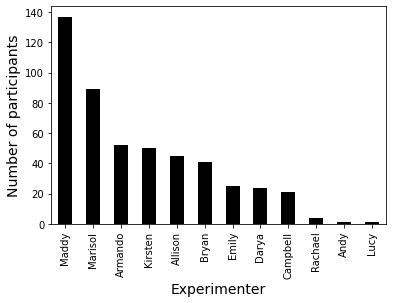

In [6]:
demographics['Experimenter'].value_counts().plot(kind='bar', color='k');
plt.xlabel('Experimenter', fontsize=14);
plt.ylabel('Number of participants', fontsize=14);

# Participant count by experiment

Match up with results file:
  - Demographics count: number of participants who filled out demographic information
  - Results count: number of participants whose data were analyzed (i.e., data not lost or corrupted)
  - Dropped: difference between demographics count and results count, floored at 0 (i.e., number of participants who filled out demographic information but were not included in the datasets)
  - Missing: difference between results count and demographics count, floored at 0 (i.e., number of participants who were included in the dataset but did not fill out a demographic survey)

In [7]:
counts = pd.DataFrame(demographics['Experiment'].value_counts()).rename({'Experiment': 'Demographics count'}, axis=1)

results_file = 'analyzed_500_iter.pkl'
results, analyses, listgroups = analyze_data(savefile=results_file)

for k in results['accuracy'].keys():
    counts.loc[k.capitalize(), 'Results count'] = results["accuracy"][k].data.reset_index()["Subject"].unique().shape[0]
counts['Results count'] = counts['Results count'].astype(int)

counts['Dropped'] = counts['Demographics count'] - counts['Results count']
counts['Missing'] = counts['Dropped'].apply(lambda x: -x if x < 0 else 0)
counts['Dropped'] = counts['Dropped'].apply(lambda x: x if x >= 0 else 0)

counts


,Demographics count,Results count,Dropped,Missing
Feature rich,73,67,6,0
Reduced,62,61,1,0
Adaptive,61,60,1,0
Reduced (late),55,41,14,0
Reduced (early),50,42,8,0
First letter,33,30,3,0
Category,32,30,2,0
Length,32,30,2,0
Color,32,31,1,0
Size,31,30,1,0


In [8]:
print(f"The dataset includes data from {counts.shape[0]} condition(s).")
print(f"There were a total of {counts['Demographics count'].sum()} participant(s) in the demographics file.")
print(f"{counts['Dropped'].sum()} participant(s) with demographics information were dropped from our analyses due to data corruption or failure to meet inclusion criteria.")
print(f"Data were analyzed from a total of {counts['Results count'].sum()} participant(s).")
print(f"{counts['Missing'].sum()} participant(s) opted not to fill out any demographic information.")

sanity_check = counts['Demographics count'].sum() - counts['Dropped'].sum() + counts['Missing'].sum() == counts['Results count'].sum()
if sanity_check:
    print("\n**Subject counts sanity check passed.**")
else:
    print("\n**Subject counts sanity check failed.**")

The dataset includes data from 11 condition(s).
There were a total of 490 participant(s) in the demographics file.
39 participant(s) with demographics information were dropped from our analyses due to data corruption or failure to meet inclusion criteria.
Data were analyzed from a total of 452 participant(s).
1 participant(s) opted not to fill out any demographic information.

**Subject counts sanity check passed.**


# Demographics by experiment...

## Age

In [9]:
demographics[['Experiment', 'Age']].groupby('Experiment').describe()

Age                                                    
                count       mean       std   min    25%   50%   75%   max
Experiment                                                               
Adaptive         60.0  19.250000  1.083388  18.0  18.75  19.0  20.0  22.0
Category         32.0  19.093750  1.279097  18.0  18.00  19.0  20.0  23.0
Color            32.0  18.656250  0.901947  18.0  18.00  18.0  19.0  22.0
Feature rich     71.0  19.464789  1.991632  17.0  18.00  19.0  20.0  31.0
First letter     32.0  18.687500  0.780302  18.0  18.00  19.0  19.0  21.0
Length           29.0  19.275862  2.085606  18.0  18.00  19.0  19.0  29.0
Location         29.0  18.793103  0.861034  17.0  18.00  19.0  19.0  21.0
Reduced          61.0  18.639344  0.895038  18.0  18.00  18.0  19.0  21.0
Reduced (early)  50.0  19.140000  1.324957  17.0  18.00  19.0  20.0  22.0
Reduced (late)   53.0  19.396226  1.097893  18.0  19.00  19.0  20.0  22.0
Size             31.0  19.322581  1.351224  18.0  18.00  19.0  20.0  22.0

## Gender

In [10]:
pd.DataFrame(demographics[['Experiment', 'Gender']].groupby('Experiment').value_counts())

0
Experiment      Gender                  
Adaptive        Female                44
                Male                  17
Category        Female                22
                Male                  10
Color           Male                  20
                Female                12
Feature rich    Female                50
                Male                  23
First letter    Female                19
                Male                  14
Length          Female                25
                Male                   7
Location        Female                22
                Male                   7
Reduced         Female                32
                Male                  30
Reduced (early) Female                31
                Male                  18
                Gender not specified   1
Reduced (late)  Female                41
                Male                  14
Size            Female                20
                Male                  10
                Gender not specified   1

## Ethnicity and race

In [11]:
pd.DataFrame(demographics[['Experiment', 'Ethnicity']].groupby('Experiment').value_counts())

0
Experiment      Ethnicity                  
Adaptive        Not Hispanic or Latino   58
                Hispanic or Latino        3
Category        Not Hispanic or Latino   28
                Hispanic or Latino        4
Color           Not Hispanic or Latino   29
                Hispanic or Latino        3
Feature rich    Not Hispanic or Latino   68
                Hispanic or Latino        3
                Ethnicity not specified   2
First letter    Not Hispanic or Latino   29
                Hispanic or Latino        4
Length          Not Hispanic or Latino   30
                Hispanic or Latino        2
Location        Not Hispanic or Latino   24
                Ethnicity not specified   3
                Hispanic or Latino        2
Reduced         Not Hispanic or Latino   55
                Hispanic or Latino        7
Reduced (early) Not Hispanic or Latino   46
                Hispanic or Latino        3
                Ethnicity not specified   1
Reduced (late)  Not Hispanic or Latino   48
                Hispanic or Latino        4
                Ethnicity not specified   3
Size            Not Hispanic or Latino   27
                Hispanic or Latino        4

In [12]:
pd.DataFrame(demographics[['Experiment', *races]].groupby('Experiment').sum())

,White,Asian,Black or African American,Race not specified,Arab,American Indian or Alaska Native,Native Hawaiian or Other Pacific Islander,Mixed race,Middle Eastern
Experiment,,,,,,,,,
Adaptive,44,13,3,0,0,0,0,1,1
Category,19,8,4,1,0,0,0,0,0
Color,25,7,0,0,1,1,0,0,0
Feature rich,54,17,3,0,0,0,1,0,0
First letter,15,13,4,1,0,2,0,0,0
Length,25,5,1,0,0,0,0,1,0
Location,15,10,5,0,0,1,1,0,0
Reduced,46,17,5,0,0,2,1,1,0
Reduced (early),41,6,5,1,0,1,0,0,0


## Education

In [13]:
pd.DataFrame(demographics[['Experiment', 'Highest degree']].groupby('Experiment').value_counts())

0
Experiment      Highest degree          
Adaptive        Some college          50
                High school graduate  11
Category        Some college          22
                High school graduate   9
                College graduate       1
Color           Some college          23
                High school graduate   8
                Some high school       1
Feature rich    Some college          54
                High school graduate  16
                College graduate       2
                Doctorate              1
First letter    Some college          24
                High school graduate   9
Length          Some college          24
                High school graduate   6
                Some high school       1
                Master's degree        1
Location        Some college          19
                High school graduate  10
Reduced         Some college          35
                High school graduate  24
                Some high school       3
Reduced (early) Some college          44
                High school graduate   6
Reduced (late)  Some college          43
                High school graduate   8
                College graduate       4
Size            Some college          21
                High school graduate  10

# Total counts and demographic breakdowns

## Counts

In [14]:
counts.sum().to_frame().rename({0: 'Total'}, axis=1)

,Total
Demographics count,490
Results count,452
Dropped,39
Missing,1


## Demographics
- Age
- Gender
- Ethnicity
- Race
- Education

In [15]:
demographics['Age'].describe()

count    480.000000
mean      19.100000
std        1.356343
min       17.000000
25%       18.000000
50%       19.000000
75%       20.000000
max       31.000000
Name: Age, dtype: float64

In [16]:
demographics['Gender'].value_counts()

Female                  318
Male                    170
Gender not specified      2
Name: Gender, dtype: int64

In [17]:
demographics['Ethnicity'].value_counts()

Not Hispanic or Latino     442
Hispanic or Latino          39
Ethnicity not specified      9
Name: Ethnicity, dtype: int64

In [18]:
demographics[['White', 'Asian',
       'Black or African American', 'Race not specified', 'Arab',
       'American Indian or Alaska Native',
       'Native Hawaiian or Other Pacific Islander', 'Mixed race',
       'Middle Eastern']].sum()

White                                        345
Asian                                        120
Black or African American                     31
Race not specified                             5
Arab                                           1
American Indian or Alaska Native              11
Native Hawaiian or Other Pacific Islander      4
Mixed race                                     3
Middle Eastern                                 1
dtype: int64

In [19]:
demographics['Highest degree'].value_counts()

Some college            359
High school graduate    117
College graduate          7
Some high school          5
Doctorate                 1
Master's degree           1
Name: Highest degree, dtype: int64

# Other demographic information
- Reading impairments
- Color vision
- Medications or injuries
- Coffee cups consumed
- Alertness

In [20]:
demographics['Reading impairments'].value_counts()

False    482
True       8
Name: Reading impairments, dtype: int64

In [21]:
demographics['Normal color vision'].value_counts()

True     489
False      1
Name: Normal color vision, dtype: int64

In [22]:
demographics['Meds or injuries'].value_counts()

None            482
ADHD              4
Dyslexia          1
Allergies         1
Torn ACL/MCL      1
Concussion        1
Name: Meds or injuries, dtype: int64

In [23]:
demographics['Coffee (cups)'].describe()

count    490.000000
mean       0.315816
std        0.579454
min        0.000000
25%        0.000000
50%        0.000000
75%        0.687500
max        3.000000
Name: Coffee (cups), dtype: float64

In [24]:
demographics['Alert'].describe()

count    490.000000
mean       0.351020
std        0.894912
min       -2.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000
Name: Alert, dtype: float64